# Phase exploration

# Setup, loading and plotting functions

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import deepdish as dd
import matplotlib.patches as mpatches

In [122]:
def load(args):
    args['image_suffix'] = args.get("image_suffix", "")
    cache_path = f"{args['save-dir']}/{args['experiment']}/{args['expid']}/cache"
    cache_file = f"{cache_path}/{args['visualization']}{args['image_suffix']}.h5"
    if os.path.isfile(cache_file):
        metrics = dd.io.load(cache_file)
        if args['visualization'] == 'performance':
            if type(metrics) == dict:
                performance = metrics['performance']
                steps = list(performance.keys())
            else:
                steps = metrics[0]
                performance = metrics[1]['performance']
            return steps, performance
        else:
            if type(metrics) == dict:
                empirical = metrics['empirical']
                theoretical = metrics.get('theoretical', None)
                layers = list(empirical.keys())
                steps = list(empirical[layers[0]].keys())
            else:
                if len(metrics) == 3:
                    steps, empirical, theoretical = metrics
                else:
                    steps, empirical = metrics
                    theoretical = None
            return steps, empirical, theoretical
    else:
        print(f"You do not have a cache file @ {cache_file}. Run the plot in the command line first")
        return (None, None, None)

In [123]:
def plot_performance(steps, performance, axes):
    color = "k"
    plot_steps = []
    for step in steps:
        if step in performance.keys() and "train_loss" in performance[step].keys():
            plot_steps.append(step)
    axes.plot(
        plot_steps, [performance[s]["train_loss"] for s in plot_steps], color=color,
        label="top1",
    )
    axes.plot(
        plot_steps,
        [performance[s]["test_loss"] for s in plot_steps],
        color=color,
        alpha=0.5,
        label="top5",
    )
    axes.tick_params(axis="y", labelcolor=color, size=20)
    axes.set_ylabel(f"loss", fontsize=20)
    plt.legend()

    axes2 = axes.twinx()
    color = "tab:blue"
    axes2.plot(
        plot_steps, [performance[s]["accuracy1"] for s in plot_steps], color=color,
        label="top1",
    )
    axes2.plot(
        plot_steps,
        [performance[s]["accuracy5"] for s in plot_steps],
        color=color,
        alpha=0.5,
        label="top5",
    )
    axes2.tick_params(axis="y", labelcolor=color)
    axes2.set_ylabel(f"accuracy", color=color, fontsize=20)

    # axes labels and title
    axes.set_xlabel("train step", fontsize=20)
    axes.set_title(f"Performance curve", fontsize=20)
    plt.legend()

In [206]:
def plot_layers(steps, metrics, axes, 
    layer_list=None, layer_wise=False, subset=0, normalize=False, legend=False,
    neuron_idx=None, step_idx_start=0, wd=None,
    color_idx_adj=0, theory_color="w", layer_filter=lambda x: True, **kwargs,
):
    position = metrics["position"] # dict of dicts: keys are layer, steps, values are 1d nparrays
    velocity = metrics["velocity"]
    layers = list(position.keys())
    if "conv" in layers[0]:
        layers = sorted(layers, key=lambda l: int(l.split("conv")[1]))
    if layer_list is not None:
        layers = [layers[i] for i in layer_list]
        
    # plot
    plot_title = "Phase portait"
    layers = [l for l in layers if layer_filter(l)]
    for i,layer in enumerate(layers):
        pos = position[layer]
        vel = velocity[layer]
        steps = [s for s in steps if s in pos.keys()]
        pos = [pos[v] for v in steps]
        vel = [vel[v] for v in steps]
        
        if layer_wise:
            pos = [np.sum(i) for i in pos]
            vel = [np.sum(i) for i in vel]
            if i == 0:
                plot_title += " per layer"
        elif neuron_idx is not None:
            pos = [i[neuron_idx] for i in pos]
            vel = [i[neuron_idx] for i in vel]
            if i == 0:
                plot_title += " for a single neuron"
        else:
            if i == 0:
                plot_title += " per neuron"
        if subset > 0:
            pos = [i[0:subset] for i in pos]
            vel = [i[0:subset] for i in vel]
        if normalize:
            pos = pos / pos[0]
            vel = vel / vel[0]
        color = plt.cm.tab20(color_idx_adj)
        if "fc" in layer:
            color_idx = int(layer.split("fc")[1]) - 1 + color_idx_adj
            color = plt.cm.tab20(color_idx)
        pos = np.array(pos)
        vel = np.array(vel)
        axes.plot(
            pos[step_idx_start:],
            vel[step_idx_start:],
            color=color,
            label=layer,
            **kwargs
        )
    
    if wd is not None:
        xlim = axes.get_xlim()
        x = np.linspace(xlim[0], xlim[1], 10)
        axes.plot(
            x,
            -2*wd*x,
            "--k",
            alpha=0.5,
        )
    axes.set_title(plot_title, fontsize=20)
    axes.set_xlabel("Position", fontsize=20)
    axes.tick_params(labelsize=20)
    if legend:
        plt.legend()

## Cifar 100

No handles with labels found to put in legend.


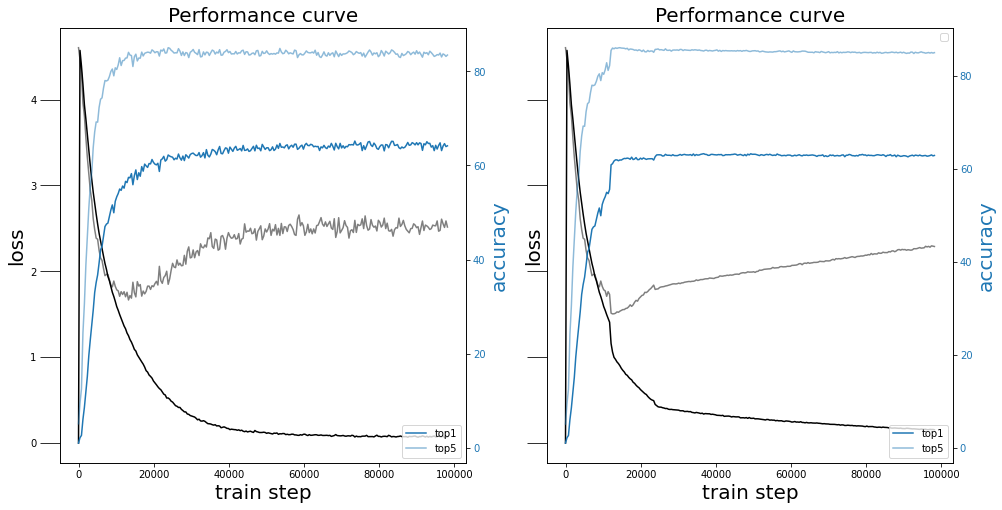

In [181]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/convergenets/gs_pt_models/jv_pt_smd",
    "experiment": "cifar100",
    "expid": "pt_cifar100_vgg16bn_sgdm_lr1en2_wd1en4_bs128_nodrop_long_fine_end",
    "visualization": "performance",
}
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex='col', sharey=True) #sharex='col'

# plot data
ax = axs[0]
steps, performance = load(args)
plot_performance(steps, performance, ax)

args["expid"]= "pt_cifar100_vgg16bn_sgdm_lr1en2_wd1en4_bs128_long_fine_end"
# plot data
ax = axs[1]
steps, performance = load(args)
plot_performance(steps, performance, ax)
plt.show()

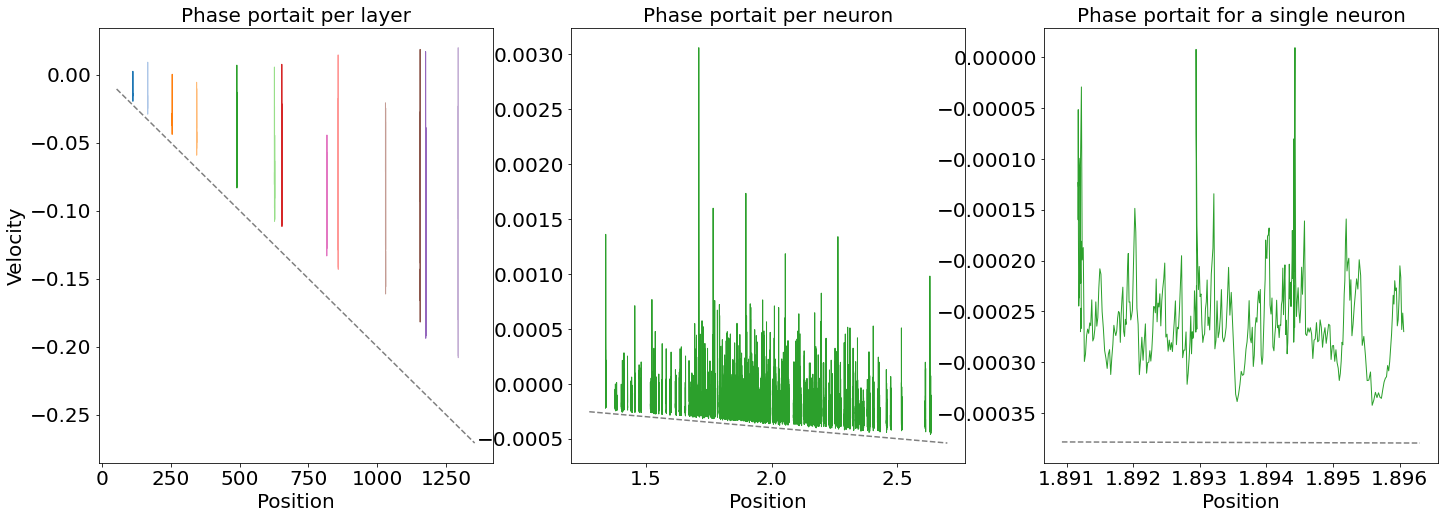

In [187]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/convergenets/gs_pt_models/jv_pt_smd",
    "experiment": "cifar100",
    "expid": "pt_cifar100_vgg16bn_sgdm_lr1en2_wd1en4_bs128_nodrop_long_fine_end",
    "visualization": "phase",
}

nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex='col')#, sharey=True) #sharex='col'

steps, metrics, _ = load(args)

ax = axs[0]
plot_layers(steps, metrics, ax, layer_wise=True, 
     layer_filter=lambda x: "conv" in x,
     neuron_idx=16, step_idx_start=250, wd=1e-4,
     **{"lw":1, "alpha":1}
)
ax.set_ylabel("Velocity", fontsize=20)

ax = axs[1]
plot_layers(steps, metrics, ax, layer_wise=False, 
     layer_filter=lambda x:  "conv5" == x, #"conv" in x,
     neuron_idx=None, step_idx_start=250, wd=1e-4,
     **{"lw":1, "alpha":1}
)

ax = axs[2]
plot_layers(steps, metrics, ax, layer_wise=False, 
     layer_filter=lambda x:  "conv5" == x, #"conv" in x,
     neuron_idx=16, step_idx_start=250, wd=1e-4,
     **{"lw":1, "alpha":1}
)


plt.show()


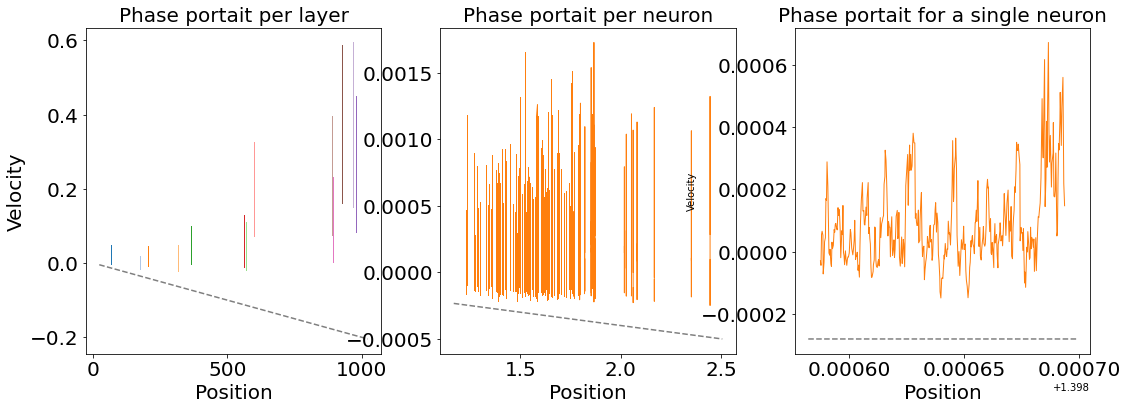

In [188]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/convergenets/gs_pt_models/jv_pt_smd",
    "experiment": "cifar100",
    "expid": "pt_cifar100_vgg16bn_sgdm_lr1en2_wd1en4_bs128_long_fine_end",
    "visualization": "phase",
}

nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows))

steps, metrics, _ = load(args)

ax = axs[0]
plot_layers(steps, metrics, ax, layer_wise=True, 
     layer_filter=lambda x: "conv" in x,
     neuron_idx=16, step_idx_start=250, wd=1e-4,
     **{"lw":1, "alpha":1}
)
ax.set_ylabel("Velocity", fontsize=20)

ax = axs[1]
plot_layers(steps, metrics, ax, layer_wise=False, 
     layer_filter=lambda x:  "conv3" == x, #"conv" in x,
     neuron_idx=None, step_idx_start=250, wd=1e-4,
     **{"lw":1, "alpha":1}
)

ax = axs[2]
plot_layers(steps, metrics, ax, layer_wise=False, 
     layer_filter=lambda x:  "conv3" == x, #"conv" in x,
     neuron_idx=16, step_idx_start=250, wd=1e-4,
     **{"lw":1, "alpha":1}
)

# tick params and axis labels
ax.set_xlabel("Position")
ax.set_ylabel("Velocity")

plt.show()



## Some MNIST models with varying WD

No handles with labels found to put in legend.


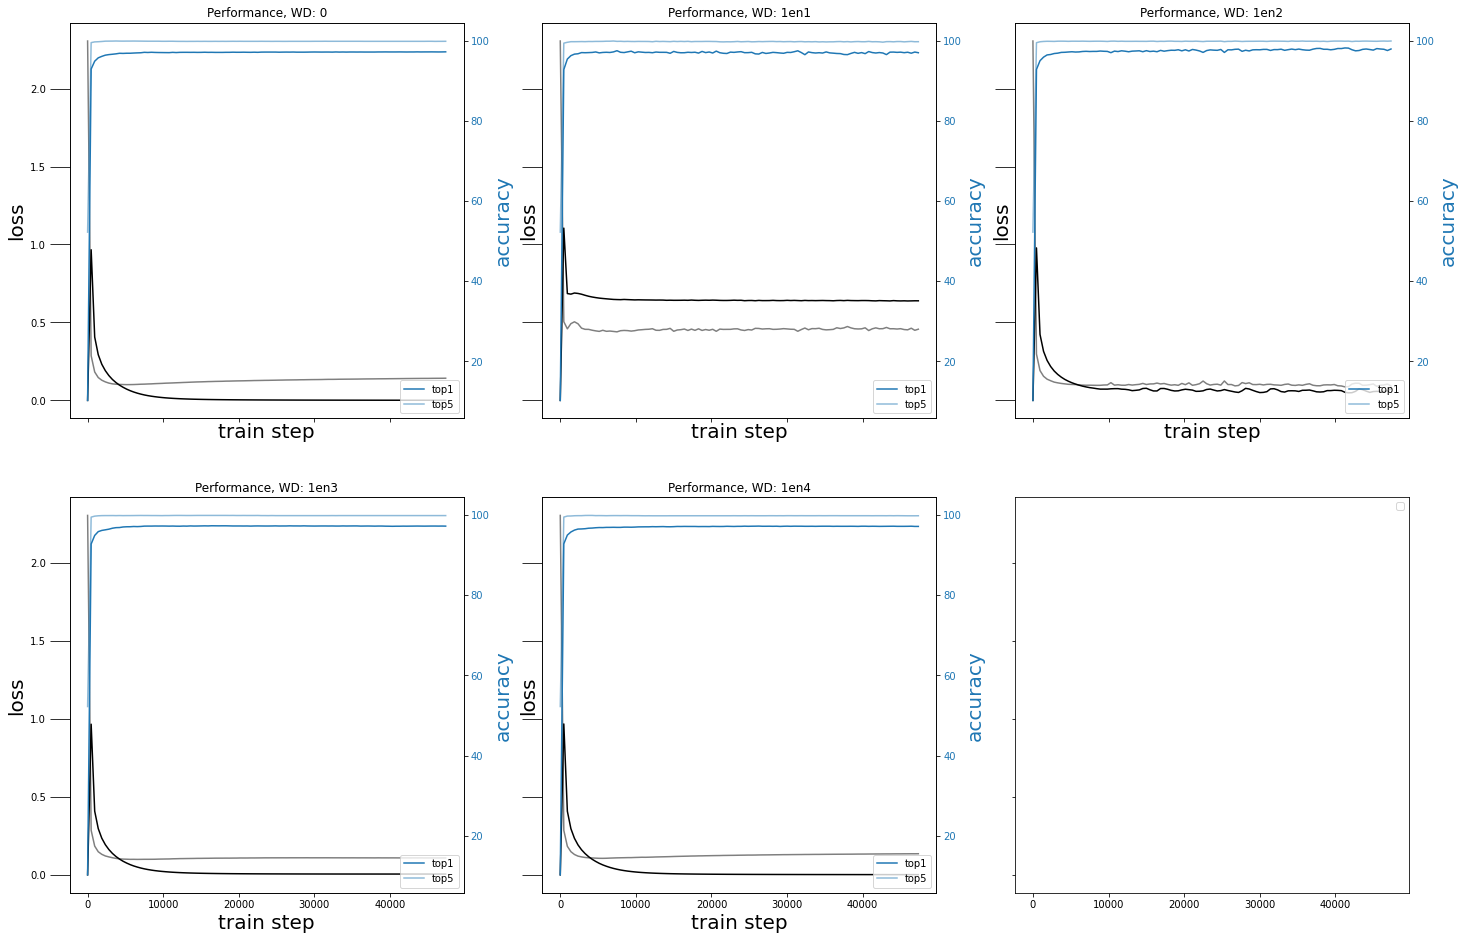

In [213]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/convergenets/gs_pt_models/jv_pt_smd",
    "experiment": "mnist",
    "visualization": "performance",
}
nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex='col', sharey=True) #sharex='col'

wds = ["0", "1en1", "1en2", "1en3", "1en4"]

for i in range(nrows):
    for j in range(ncols):
        # plot data
        ax = axs[i,j]
        k = ncols*i + j
        if k < len(wds):
            args["expid"] = f"pt_mnist_fcbn_sgdm_lr1en3_wd{wds[k]}_bs128_nodrop_long_fine_end"
            steps, performance = load(args)
            plot_performance(steps, performance, ax)
            ax.set_title(f"Performance, WD: {wds[k]}")

plt.show()

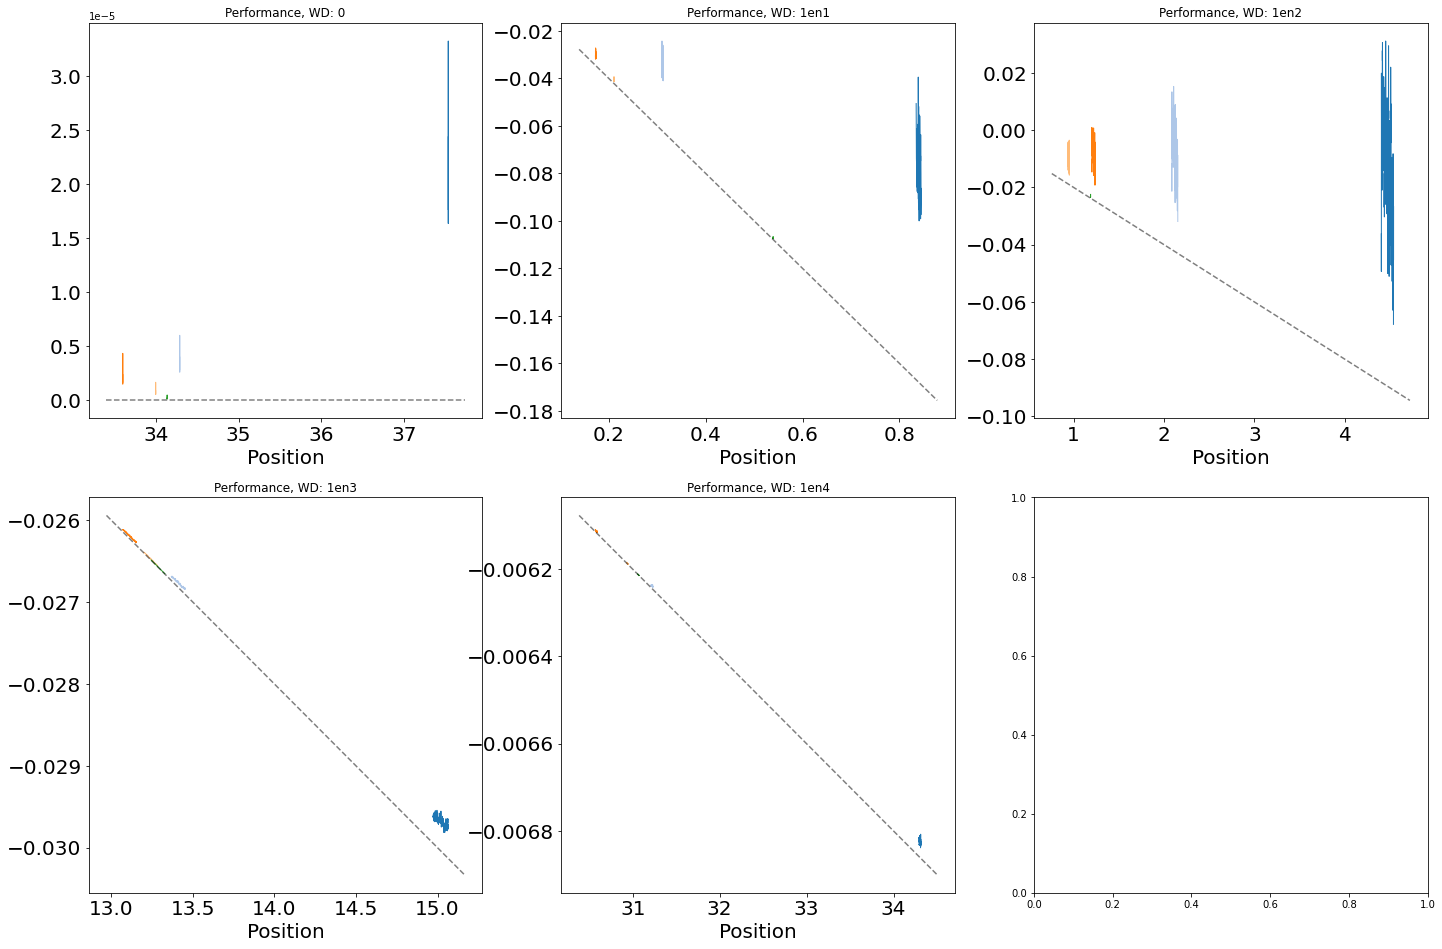

In [208]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/convergenets/gs_pt_models/jv_pt_smd",
    "experiment": "mnist",
    "visualization": "phase",
}
nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows))

wds = ["0", "1en1", "1en2", "1en3", "1en4"]

for i in range(nrows):
    for j in range(ncols):
        # plot data
        ax = axs[i,j]
        k = ncols*i + j
        if k < len(wds):
            args["expid"] = f"pt_mnist_fcbn_sgdm_lr1en3_wd{wds[k]}_bs128_nodrop_long_fine_end"
            steps, metrics, _ = load(args)
            plot_layers(steps, metrics, ax, layer_wise=True, 
                 layer_filter=lambda x: "fc" in x,
                 neuron_idx=16, step_idx_start=250, wd=float(wds[k].replace("n", "-")),
                 **{"lw":1, "alpha":1}
            )
            ax.set_title(f"Performance, WD: {wds[k]}")

plt.show()

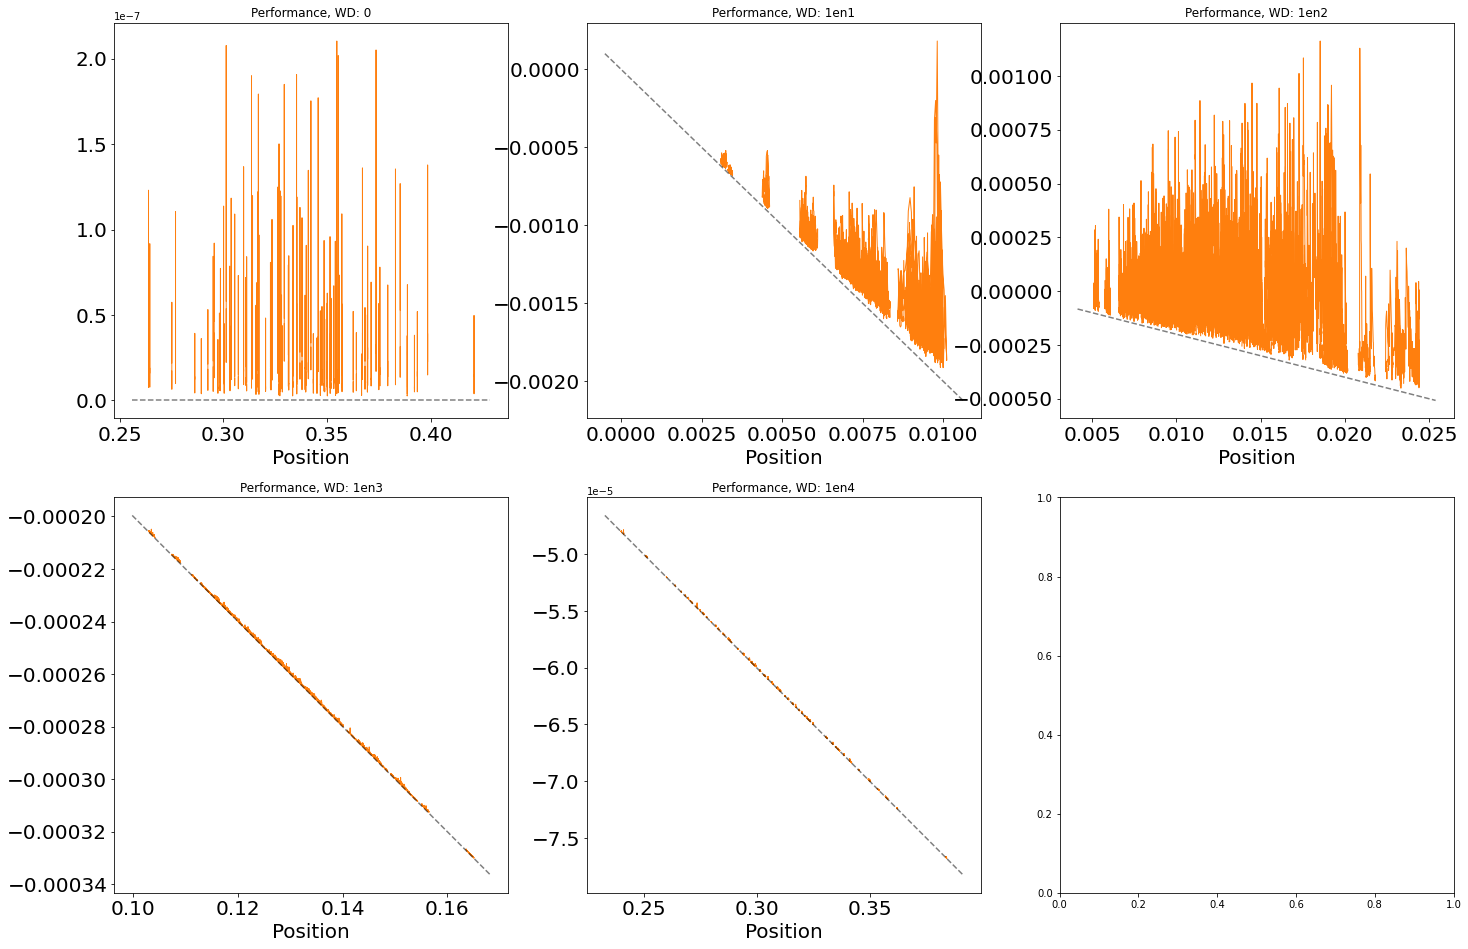

In [212]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/convergenets/gs_pt_models/jv_pt_smd",
    "experiment": "mnist",
    "visualization": "phase",
}
nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows))
wds = ["0", "1en1", "1en2", "1en3", "1en4"]

for i in range(nrows):
    for j in range(ncols):
        # plot data
        ax = axs[i,j]
        k = ncols*i + j
        if k < len(wds):
            args["expid"] = f"pt_mnist_fcbn_sgdm_lr1en3_wd{wds[k]}_bs128_nodrop_long_fine_end"
            steps, metrics, _ = load(args)
            plot_layers(steps, metrics, ax, layer_wise=False, 
                 layer_filter=lambda x:  "fc3" == x, #"conv" in x,
                 neuron_idx=None, step_idx_start=100, wd=float(wds[k].replace("n", "-")),
                 **{"lw":1, "alpha":1}
            )
            ax.set_title(f"Performance, WD: {wds[k]}")

plt.show()

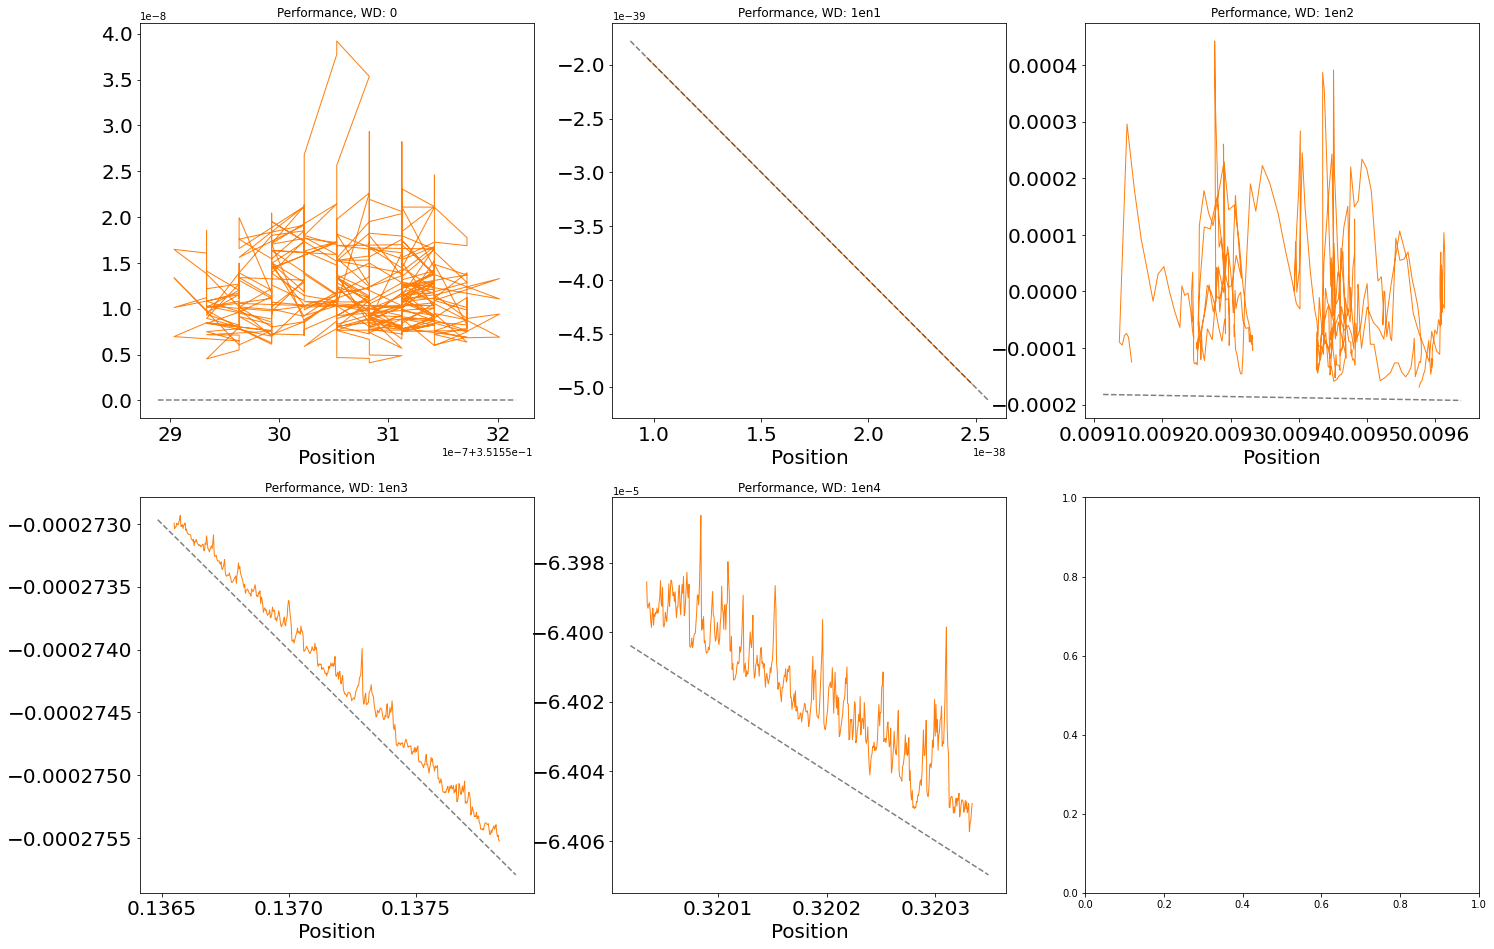

In [211]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/convergenets/gs_pt_models/jv_pt_smd",
    "experiment": "mnist",
    "visualization": "phase",
}
nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows))
wds = ["0", "1en1", "1en2", "1en3", "1en4"]

for i in range(nrows):
    for j in range(ncols):
        # plot data
        ax = axs[i,j]
        k = ncols*i + j
        if k < len(wds):
            args["expid"] = f"pt_mnist_fcbn_sgdm_lr1en3_wd{wds[k]}_bs128_nodrop_long_fine_end"
            steps, metrics, _ = load(args)
            plot_layers(steps, metrics, ax, layer_wise=False, 
                 layer_filter=lambda x:  "fc3" == x, #"conv" in x,
                 neuron_idx=16, step_idx_start=100, wd=float(wds[k].replace("n", "-")),
                 **{"lw":1, "alpha":1}
            )
            ax.set_title(f"Performance, WD: {wds[k]}")

plt.show()